# An implementation of the Ant miner paper for Emotion Recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm


In [4]:
#Level of discretization of the continuous data
bins = [5 for _ in range(len(df.columns)-1)]

(array([ 76., 471., 543., 261.,  89.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

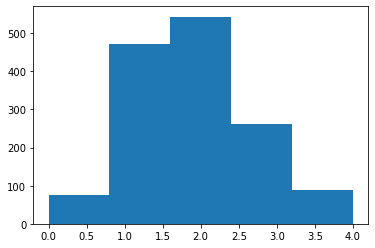

In [5]:
plt.hist(pd.cut(df['f0'], bins=bins[0], labels=range(bins[0])), bins = bins[0])

In [6]:
discreet = pd.DataFrame()

In [7]:
for i, column in enumerate(df.drop('class', axis=1).columns):
    discreet[column] = pd.cut(df[column], bins=bins[i], labels=range(bins[i]))

In [9]:
discreet['class'] = df['class']
discreet.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,1,2,2,2,3,1,2,3,2,3,...,0,1,1,0,4,0,0,1,0,neutral
1,2,2,2,2,3,0,2,2,2,3,...,0,1,0,0,4,0,0,0,1,neutral
2,1,2,1,2,3,1,2,2,2,3,...,0,1,1,0,3,1,0,1,0,neutral
3,1,2,2,3,3,1,2,2,2,3,...,0,2,0,0,4,0,0,0,0,neutral
4,1,1,1,2,3,0,2,2,3,3,...,1,1,1,0,2,1,1,1,1,calm


In [10]:
emotions = discreet['class'].unique()
emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised'], dtype=object)

In [11]:
train, test = np.split(discreet.sample(frac=1), [int(0.75*len(discreet))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
test_len, train_len, total_len

(360, 1080, 1440)

# Entropy values
H will be a matrix of size (bins x features). Computed in a vectorized way to save time (This would take like 10 mins if it was in a for loop, now it takes 10s). <br>
Ok fine I'm looping through the 6 emotions so techhhhnically it's not fully vectorized. Anyway we're computing H only once so I took lite

In [12]:
H = np.zeros((bins[0], len(train.columns)-1, len(emotions)))

In [17]:
# The most compute intensive step
for e, emotion in enumerate(emotions):
            H[:, :, e] = train.loc[train['class']==emotion].drop('class', axis=1).apply(pd.Series.value_counts).to_numpy()
#H

In [18]:
sums = np.sum(H, axis=2)
#sums

In [19]:
repeated_sums = np.repeat(sums[:, :, np.newaxis], H.shape[2], axis=2)
#repeated_sums[:, :, 1]

In [20]:
P = np.divide(H, repeated_sums, out=np.zeros_like(H), where=repeated_sums!=0)

In [21]:
logP = np.log2(P, out=np.zeros_like(P), where=P>0)
#logP

In [22]:
H = -np.sum(np.multiply(P, logP), axis=2)
#H

In [23]:
class Rule:
    def __init__(self):
        self.terms = {}
        self.emotion = 0
    
    def match(instance):
        for key, value in instance.items():
            if key in self.terms and self.terms[key] != value:
                return False
        return True